<a href="https://colab.research.google.com/github/Chaitanya-Shikhare/tensorflow-deep-learning/blob/main/04_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct 13 08:22:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    86W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-10-13 08:22:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  52.4MB/s    in 3.1s    

2021-10-13 08:22:50 (52.4 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,)) # Freeze already learn patterns

  # Create our own model
  model= tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")                          
  ])

  return model

In [9]:
# Create ResNet TF Hub Feature Extraction model

resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [12]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20211013-082259
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 1.9134 - accuracy: 0.3813 - val_loss: 1.1796 - val_accuracy: 0.6228
Epoch 2/5
24/24 [==============================] - 22s 938ms/step - loss: 0.9164 - accuracy: 0.7333 - val_loss: 0.8546 - val_accuracy: 0.7280
Epoch 3/5
24/24 [==============================] - 22s 936ms/step - loss: 0.6313 - accuracy: 0.8120 - val_loss: 0.7679 - val_accuracy: 0.7492
Epoch 4/5
24/24 [==============================] - 22s 933ms/step - loss: 0.4776 - accuracy: 0.8627 - val_loss: 0.6906 - val_accuracy: 0.7804
Epoch 5/5
24/24 [==============================] - 22s 929ms/step - loss: 0.3803 - accuracy: 0.9040 - val_loss: 0.6797 - val_accuracy: 0.7800


In [13]:
import matplotlib.pyplot as plt
def plot_loss_curve(history):

 loss = history.history['loss']
 val_loss= history.history['val_loss']

 accuracy = history.history['accuracy']
 val_accuracy = history.history['val_accuracy']
 epochs = range(len(history.history['loss']))

# Plot loss

 plt.plot(epochs, loss, label='training_loss')
 plt.plot(epochs, val_loss, label='val_loss')
 plt.title('Loss')
 plt.xlabel('Epochs')
 plt.legend()

# Plot accuracy
 plt.figure()
 plt.plot(epochs, accuracy, label='training_accuracy')
 plt.plot(epochs, val_accuracy, label='val_accuracy')
 plt.title('Accuracy')
 plt.xlabel('Epochs')
 plt.legend();

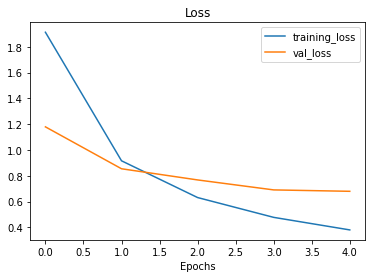

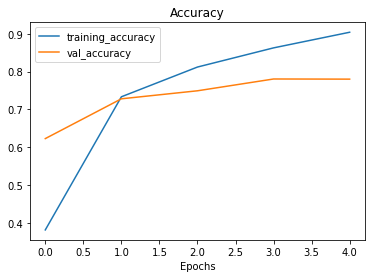

In [14]:
plot_loss_curve(resnet_history)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
# Create efficent model
efficientnet_model = create_model(model_url=efficientnet_url,
                              num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])
efficientnet_history = efficientnet_model.fit (train_data_10_percent,
                                               epochs=5,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=len(test_data),
                                               callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                      experiment_name="efficentnetB0")])


Saving TensorBoard log files to: tensorflow_hub/efficentnetB0/20211013-082514
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.7880 - accuracy: 0.4560 - val_loss: 1.2587 - val_accuracy: 0.7344
Epoch 2/5
24/24 [==============================] - 19s 816ms/step - loss: 1.0349 - accuracy: 0.7840 - val_loss: 0.8647 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 19s 820ms/step - loss: 0.7494 - accuracy: 0.8453 - val_loss: 0.6967 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 19s 817ms/step - loss: 0.6028 - accuracy: 0.8747 - val_loss: 0.6137 - val_accuracy: 0.8472
Epoch 5/5
24/24 [==============================] - 19s 819ms/step - loss: 0.5095 - accuracy: 0.9027 - val_loss: 0.5595 - val_accuracy: 0.8604


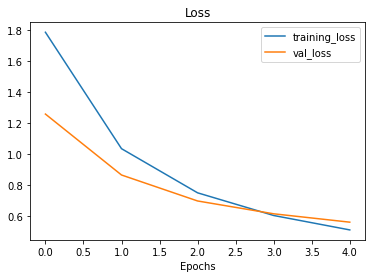

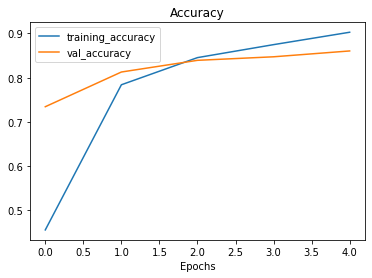

In [17]:
plot_loss_curve(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
# upload  Tensorborad dev records
!tensorborad dev upload  --logdir ./tensorflow_hub/ \
  --name "EfficentNEtB0 vs Resnet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

/bin/bash: tensorborad: command not found


In [20]:

# Check out experiments
#!tensorboard dev list